## 개인미션풀이

In [5]:
import numpy as np

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = x <= 0
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dx = dout.copy()
        dx[self.mask] = 0
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

def cross_entropy_error(p, r):
    delta = 1e-7
    batch_size = p.shape[0]
    total_loss = -np.sum(r * np.log(p + delta))
    return total_loss / batch_size

def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in np.ndindex(x.shape):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

def softmax(x):
    if x.ndim == 1:
        c = np.max(x)
        exp_a = np.exp(x-c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y
    elif x.ndim == 2:
        c = np.max(x, axis = 1).reshape(-1, 1)
        exp_a = np.exp(x - c)
        sum_exp_a = np.sum(exp_a, axis = 1).reshape(-1, 1)
        y = exp_a / sum_exp_a
        return y

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

class Affine:
    def __init__(self, w, b):
        self.w = w
        self.b = b
        self.x = None
        self.dw = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = x @ self.w + self.b
        return out

    def backward(self, dout):
        dx = dout @ self.w.T
        self.dw = self.x.T @ dout
        self.db = np.sum(dout, axis = 0)
        return dx

from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, I, H, O):
        self.params = {}
        self.params['w1'] = np.random.randn(I, H)
        self.params['b1'] = np.random.randn(H)
        self.params['w2'] = np.random.randn(H, O)
        self.params['b2'] = np.random.randn(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Sigmoid'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for i in self.layers.values():
            x = i.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1:
            t = np.argmax(t, axis = 1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for i in layers:
            dout = i.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        return grads

In [6]:
import pickle
f = open("mnist.dat", 'rb')
train, test = pickle.load(f)
f.close()

train_x, train_y = train
test_x, test_y = test

train_scaled = train_x.reshape(-1, 28*28) / 255
test_scaled = test_x.reshape(-1, 28*28) / 255

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_y = encoder.fit_transform(train_y.reshape(-1, 1)).toarray()
test_y = encoder.fit_transform(test_y.reshape(-1, 1)).toarray()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []

In [7]:
for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    for key in ('w1', 'b1', 'w2', 'b2'):
        net.params[key] -= grad[key] * lr

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 100 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

100회 학습 / 정확도(훈련) : 0.331, 정확도(시험) : 0.337
200회 학습 / 정확도(훈련) : 0.489, 정확도(시험) : 0.491
300회 학습 / 정확도(훈련) : 0.583, 정확도(시험) : 0.586
400회 학습 / 정확도(훈련) : 0.642, 정확도(시험) : 0.647
500회 학습 / 정확도(훈련) : 0.678, 정확도(시험) : 0.689
600회 학습 / 정확도(훈련) : 0.705, 정확도(시험) : 0.715
700회 학습 / 정확도(훈련) : 0.727, 정확도(시험) : 0.737
800회 학습 / 정확도(훈련) : 0.743, 정확도(시험) : 0.752
900회 학습 / 정확도(훈련) : 0.756, 정확도(시험) : 0.767
1000회 학습 / 정확도(훈련) : 0.766, 정확도(시험) : 0.777


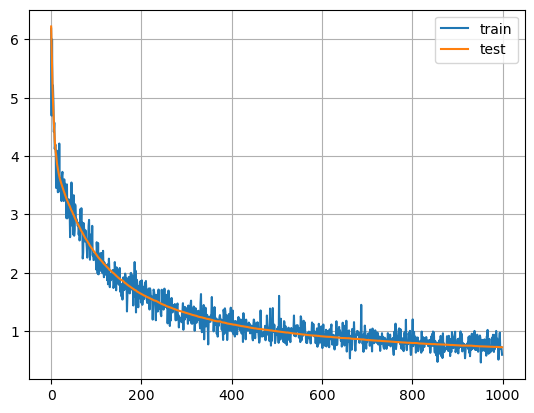

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.grid()
plt.show()

In [10]:
class ThreeLayerNet:
    def __init__(self, I, H1, H2, O):
        self.params = {}
        self.params['w1'] = np.random.randn(I, H1)
        self.params['b1'] = np.random.randn(H1)
        self.params['w2'] = np.random.randn(H1, H2)
        self.params['b2'] = np.random.randn(H2)
        self.params['w3'] = np.random.randn(H2, O)
        self.params['b3'] = np.random.randn(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Relu'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.layers['Relu'] = Relu()
        self.layers['Affine3'] = Affine(self.params['w3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for i in self.layers.values():
            x = i.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1:
            t = np.argmax(t, axis = 1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for i in layers:
            dout = i.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        grads['w3'] = self.layers['Affine3'].dw
        grads['b3'] = self.layers['Affine3'].db
        return grads

In [15]:
import pickle
f = open("mnist.dat", 'rb')
train, test = pickle.load(f)
f.close()

train_x, train_y = train
test_x, test_y = test

train_scaled = train_x.reshape(-1, 28*28) / 255
test_scaled = test_x.reshape(-1, 28*28) / 255

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_y = encoder.fit_transform(train_y.reshape(-1, 1)).toarray()
test_y = encoder.fit_transform(test_y.reshape(-1, 1)).toarray()

train_size = len(train_scaled)
batch_size = 1000
lr = 0.1

net = ThreeLayerNet(784, 50, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []

In [16]:
for i in range(1, 5001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    for key in ('w1', 'b1', 'w2', 'b2', 'w3', 'b3'):
        net.params[key] -= grad[key] * lr

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 1000 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

1000회 학습 / 정확도(훈련) : 0.502, 정확도(시험) : 0.503
2000회 학습 / 정확도(훈련) : 0.651, 정확도(시험) : 0.659
3000회 학습 / 정확도(훈련) : 0.739, 정확도(시험) : 0.745
4000회 학습 / 정확도(훈련) : 0.753, 정확도(시험) : 0.757
5000회 학습 / 정확도(훈련) : 0.786, 정확도(시험) : 0.785


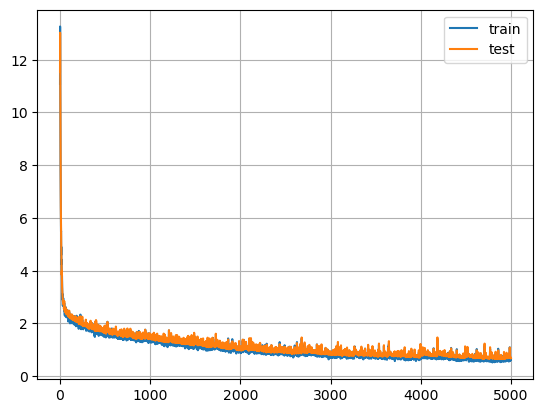

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.grid()
plt.show()

## 연습문제풀이

## 학습률
딥러닝 모델 학습에 있어 '학습률(Learning Rate)'은 모델의 성능과 학습 속도를 결정하는 가장 중요한 하이퍼파라미터 중 하나입니다. 학습률은 모델이 학습 과정에서 가중치(weight)를 얼마나 크게 업데이트할지를 제어하며, 손실 함수(loss function)를 최소화하는 최적의 가중치를 찾아가는 과정에 직접적인 영향을 미칩니다.

In [18]:
class TwoLayerNet:
    def __init__(self, I, H, O):

        a = np.sqrt(2 / (I + H))
        self.params = {}
        self.params['w1'] = np.random.randn(I, H) * a
        self.params['b1'] = np.random.randn(H)
        self.params['w2'] = np.random.randn(H, O)
        self.params['b2'] = np.random.randn(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Relu'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for i in self.layers.values():
            x = i.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1:
            t = np.argmax(t, axis = 1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for i in layers:
            dout = i.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        return grads

In [20]:
class SGD:
    def __init__(self, lr = 0.1):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= grads[key] * self.lr

In [25]:
train_size = len(train_scaled)
batch_size = 100

optimizer = SGD()

net = TwoLayerNet(784, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []

for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params
    optimizer.update(params, grad)

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 100 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

100회 학습 / 정확도(훈련) : 0.685, 정확도(시험) : 0.699
200회 학습 / 정확도(훈련) : 0.725, 정확도(시험) : 0.734
300회 학습 / 정확도(훈련) : 0.747, 정확도(시험) : 0.753
400회 학습 / 정확도(훈련) : 0.754, 정확도(시험) : 0.762
500회 학습 / 정확도(훈련) : 0.761, 정확도(시험) : 0.774
600회 학습 / 정확도(훈련) : 0.751, 정확도(시험) : 0.760
700회 학습 / 정확도(훈련) : 0.776, 정확도(시험) : 0.784
800회 학습 / 정확도(훈련) : 0.779, 정확도(시험) : 0.782
900회 학습 / 정확도(훈련) : 0.784, 정확도(시험) : 0.788
1000회 학습 / 정확도(훈련) : 0.802, 정확도(시험) : 0.809


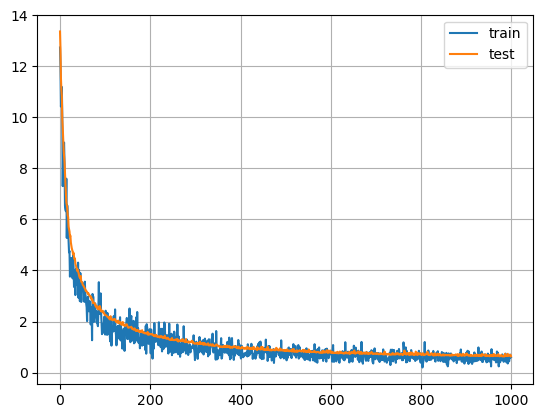

In [26]:
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.grid()
plt.show()

### 확률적 경사 하강법(Stochastic Gradient Descent, SGD)
모델의 학습 가능한 파라미터(params)와 해당 파라미터에 대한 손실 함수의 기울기(grads)를 입력받아, 설정된 학습률(self.lr)을 사용하여 파라미터를 업데이트하는 기능을 수행합니다.

### 모멘텀(Momentum)
모멘텀은 경사 하강법에 '관성' 개념을 도입한 것으로, 이전에 이동했던 방향의 관성을 유지하면서 현재 기울기 방향으로 파라미터를 업데이트합니다. 이를 통해 지역 최저점에 덜 갇히고, 최적점으로 가는 길에 진동을 줄여 수렴 속도를 개선하는 효과가 있습니다.

In [27]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                # 속도가 모두 0.
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] + grads[key]
            params[key] -= self.lr * self.v[key]

In [28]:
train_size = len(train_scaled)
batch_size = 100

optimizer = Momentum()

net = TwoLayerNet(784, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []

for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params
    optimizer.update(params, grad)

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 100 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

100회 학습 / 정확도(훈련) : 0.711, 정확도(시험) : 0.720
200회 학습 / 정확도(훈련) : 0.750, 정확도(시험) : 0.755
300회 학습 / 정확도(훈련) : 0.766, 정확도(시험) : 0.774
400회 학습 / 정확도(훈련) : 0.781, 정확도(시험) : 0.788
500회 학습 / 정확도(훈련) : 0.779, 정확도(시험) : 0.780
600회 학습 / 정확도(훈련) : 0.792, 정확도(시험) : 0.796
700회 학습 / 정확도(훈련) : 0.798, 정확도(시험) : 0.808
800회 학습 / 정확도(훈련) : 0.806, 정확도(시험) : 0.810
900회 학습 / 정확도(훈련) : 0.810, 정확도(시험) : 0.814
1000회 학습 / 정확도(훈련) : 0.819, 정확도(시험) : 0.825


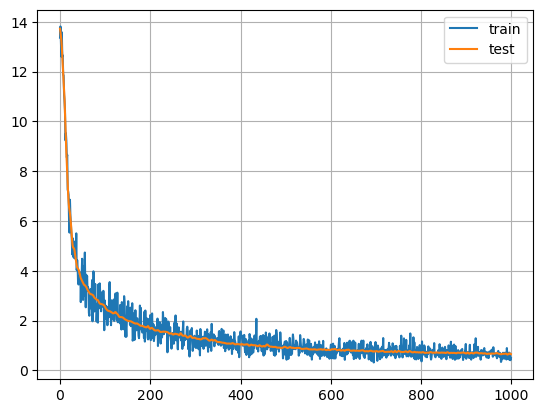

In [29]:
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.grid()
plt.show()

### AdaGrad(Adaptive Gradient Algorithm)
AdaGrad는 학습률을 모든 파라미터에 대해 동일하게 적용하는 대신, 각 파라미터마다 과거 기울기의 제곱 값을 누적하여 학습률을 개별적으로 조절하는 방식입니다. 자주 업데이트되는(기울기가 큰) 파라미터는 학습률을 작게 만들고, 드물게 업데이트되는(기울기가 작은) 파라미터는 학습률을 크게 만들어 학습 효율성을 높입니다. 특히 스파스(Sparse)한 데이터에 효과적인 것으로 알려져 있습니다.

In [33]:
# Momentum: 기울기가 크면 더 크게, 작으면 더 작게.
# Adagrad: 기울기가 크면 작게, 작으면 크게.

class AdaGrad:
    def __init__(self, lr = 0.01, epsilon = 1e-8):
        self.lr = lr
        self.epsilon = epsilon
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + self.epsilon)

In [34]:
train_size = len(train_scaled)
batch_size = 100

optimizer = AdaGrad()

net = TwoLayerNet(784, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []

for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params
    optimizer.update(params, grad)

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 100 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

100회 학습 / 정확도(훈련) : 0.461, 정확도(시험) : 0.479
200회 학습 / 정확도(훈련) : 0.562, 정확도(시험) : 0.574
300회 학습 / 정확도(훈련) : 0.613, 정확도(시험) : 0.625
400회 학습 / 정확도(훈련) : 0.646, 정확도(시험) : 0.656
500회 학습 / 정확도(훈련) : 0.670, 정확도(시험) : 0.679
600회 학습 / 정확도(훈련) : 0.688, 정확도(시험) : 0.695
700회 학습 / 정확도(훈련) : 0.700, 정확도(시험) : 0.708
800회 학습 / 정확도(훈련) : 0.713, 정확도(시험) : 0.723
900회 학습 / 정확도(훈련) : 0.723, 정확도(시험) : 0.733
1000회 학습 / 정확도(훈련) : 0.732, 정확도(시험) : 0.743


### Adam(Adaptive Moment Estimation)
Adam은 현재 가장 널리 사용되는 옵티마이저 중 하나로, Momentum과 RMSProp (또는 AdaGrad의 변형)의 장점을 결합한 방식입니다. Adam은 각 파라미터에 대해 다음과 같은 두 가지 이동 평균을 계산하여 사용합니다.

1. 첫 번째 모멘트 (First Moment, m): 기울기의 지수 가중 평균. Momentum의 속도와 유사합니다. (과거 기울기의 방향 정보를 축적)
2. 두 번째 모멘트 (Second Moment, v): 기울기 제곱의 지수 가중 평균. RMSProp의 s 또는 AdaGrad의 h와 유사합니다. (과거 기울기 크기의 정보를 축적하여 학습률 조절)

In [40]:
class Adam:
    # __init__ 메서드: 학습률(lr), beta1, beta2, 엡실론(epsilon)을 인자로 받습니다.
    # self.m: 첫 번째 모멘트 (기울기 평균)를 저장할 딕셔너리
    # self.v: 두 번째 모멘트 (기울기 제곱 평균)를 저장할 딕셔너리
    # self.iter: 업데이트 스텝 카운터 (Bias Correction에 사용)
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.iter = 0 # 학습 횟수 카운터 (Bias Correction에 사용)
        self.m = None # 1차 모멘트 (기울기의 지수 가중 평균)
        self.v = None # 2차 모멘트 (기울기 제곱의 지수 가중 평균)

    # update 메서드: 파라미터(params)와 기울기(grads)를 받아 파라미터를 업데이트합니다.
    def update(self, params, grads):
        # 업데이트 스텝 카운터를 1 증가시킵니다. (Bias Correction 계산에 필요)
        self.iter += 1

        # 첫 번째 업데이트 스텝인 경우, m과 v 딕셔너리를 초기화합니다.
        # 각 파라미터에 대해 m과 v를 0으로 채워진 배열로 초기화합니다.
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        # params 딕셔너리의 모든 키(파라미터)를 순회합니다.
        for key in params.keys():
            # 1. 1차 모멘트 (m) 업데이트: 기울기의 지수 가중 평균 계산
            # m = beta1 * m_prev + (1 - beta1) * gradient
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]

            # 2. 2차 모멘트 (v) 업데이트: 기울기 제곱의 지수 가중 평균 계산 (원소별 제곱)
            # v = beta2 * v_prev + (1 - beta2) * (gradient * gradient)
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2) # np.power(grads[key], 2) 도 가능

            # 3. 1차 모멘트 편향 보정 (Bias Correction for first moment)
            # m_hat = m / (1 - beta1^t)
            m_hat = self.m[key] / (1 - self.beta1**self.iter)

            # 4. 2차 모멘트 편향 보정 (Bias Correction for second moment)
            # v_hat = v / (1 - beta2^t)
            v_hat = self.v[key] / (1 - self.beta2**self.iter)

            # 5. 파라미터 업데이트: Bias-corrected 모멘트들을 사용하여 업데이트 방향과 크기 조절
            # param = param - (lr / (sqrt(v_hat) + epsilon)) * m_hat
            params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

## 연습문제
1. SGD, Momentum, AdaGrad, Adam을 복습하고, 각각 학습 진도 그래프를 시각화해서 비교해보세요.

In [37]:
# 훈련세트만 각 4개의 최적화 함수 학습 진도 그래프 그리기!
# 어떤 것이 가장 좋게 나오는지 시각화.

train_size = len(train_scaled)
batch_size = 1000

optimizer = SGD()

net = TwoLayerNet(784, 50, 10)

train_losses1 = []

for i in range(1, 5001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params
    optimizer.update(params, grad)

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses1.append(loss)

In [38]:
# 훈련세트만 각 4개의 최적화 함수 학습 진도 그래프 그리기!
# 어떤 것이 가장 좋게 나오는지 시각화.

train_size = len(train_scaled)
batch_size = 1000

optimizer = Momentum()

net = TwoLayerNet(784, 50, 10)

train_losses2 = []

for i in range(1, 5001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params
    optimizer.update(params, grad)

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses2.append(loss)

In [39]:
# 훈련세트만 각 4개의 최적화 함수 학습 진도 그래프 그리기!
# 어떤 것이 가장 좋게 나오는지 시각화.

train_size = len(train_scaled)
batch_size = 1000

optimizer = AdaGrad()

net = TwoLayerNet(784, 50, 10)

train_losses3 = []

for i in range(1, 5001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params
    optimizer.update(params, grad)

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses3.append(loss)

In [41]:
# 훈련세트만 각 4개의 최적화 함수 학습 진도 그래프 그리기!
# 어떤 것이 가장 좋게 나오는지 시각화.

train_size = len(train_scaled)
batch_size = 1000

optimizer = Adam()

net = TwoLayerNet(784, 50, 10)

train_losses4 = []

for i in range(1, 5001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params
    optimizer.update(params, grad)

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses4.append(loss)

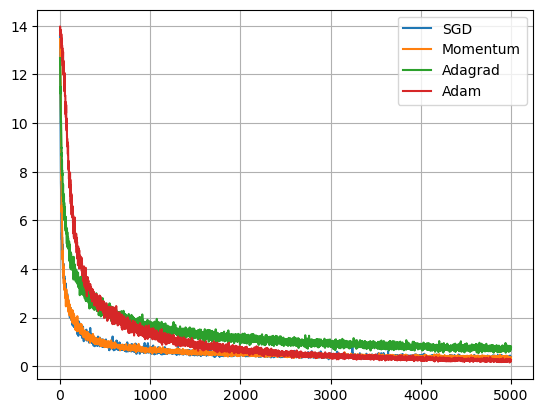

In [42]:
plt.plot(train_losses1)
plt.plot(train_losses2)
plt.plot(train_losses3)
plt.plot(train_losses4)
plt.legend(['SGD', 'Momentum', 'Adagrad', 'Adam'])
plt.grid()
plt.show()

## 가중치의 초기 값

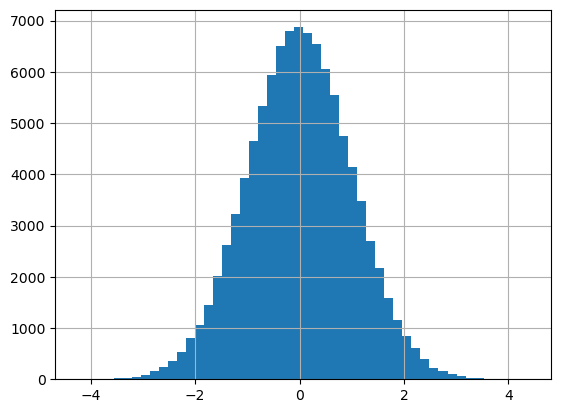

In [44]:
x = np.random.randn(1000, 100)

plt.hist(x.flatten(), bins = 50)
plt.grid()
plt.show()

In [53]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
hidden_layers = 5
activations = {}

for i in range(hidden_layers):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(100, 100)
    a = x @ w
    z = sigmoid(a)
    activations[i] = z

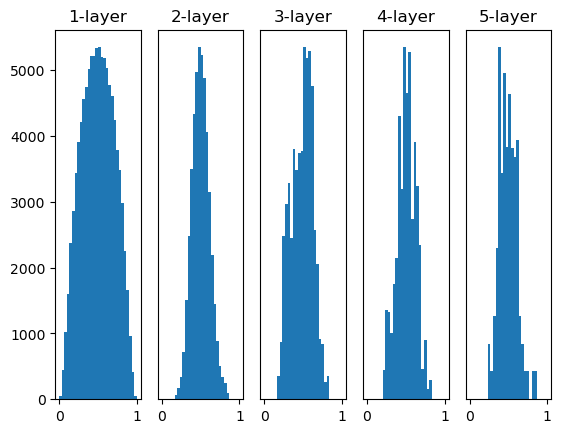

In [54]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0, 1))

plt.show()

### Xavier 초기값

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
hidden_layers = 5
activations = {}

for i in range(hidden_layers):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(100, 100) / np.sqrt(100)
    a = x @ w
    z = sigmoid(a)
    activations[i] = z

### He 초기값: 렐루에 특화된 초기값

In [55]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
hidden_layers = 5
activations = {}

for i in range(hidden_layers):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(100, 100) * np.sqrt(2 / 100)
    a = x @ w
    z = sigmoid(a)
    activations[i] = z

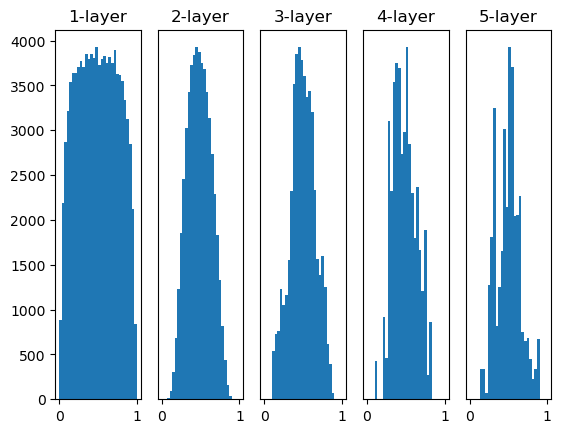

In [56]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0, 1))

plt.show()

In [ ]:
# Tensorflow: Google
# Pytorch: Facebook (이미지 검출)